In [1]:
#Data Extraction using Beautiful Soup
def data_extraction():
    #Libraries For Data Extraction
    from bs4 import BeautifulSoup
    import time
    import datetime
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.webdriver.common.by import By
    from selenium import webdriver
    
    #specify the url
    url = 'http://mmdatraffic.interaksyon.com/line-view-edsa.php'
    
    # Start the WebDriver and load the page
    wd = webdriver.Firefox()
    wd.get(url)

    # Wait for the dynamically loaded elements to show up
    WebDriverWait(wd, 10).until(
        EC.visibility_of_element_located((By.CLASS_NAME, "line-col")))

    # And grab the page HTML source
    html_page = wd.page_source
    wd.quit()

    # Now you can use html_page as you like
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html_page)

    #set time stamp.
    ts = time.time()
    timestamp = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H_%M_%S')
    stringdata = "TIMESTAMP: "+ str(timestamp)+"\n"+"\n"

    #extract name of lines
    list_of_names_html=soup.find_all('div',{'class':'line-name'})
    list_of_names = []

    for children in list_of_names_html:
        grandchildren = children.findChild("p")
        temp = grandchildren.get_text(separator=' ')
        temp = temp.split(' ')
        list_of_names.append(temp[0]) #NOTE: fix string separation
    list_of_names.pop(0) 

    #extract southbound/northbound volume
    list_of_volume_html=soup.find_all('div',{'class':'line-status'})
    list_of_southbound = []
    list_of_northbound = []

    i=1
    for children in list_of_volume_html:
        temp = children.text
        temp = temp.split()

        if(temp[1]=="LIGHT"):
            temp[1]=0
        elif(temp[1]=="MODERATE"):
            temp[1]=1
        elif(temp[1]=="HEAVY"):
            temp[1]=2

        if(i%2 == 0):
            list_of_northbound.append(temp[1])
        else:
            list_of_southbound.append(temp[1])

        i=i+1

    #save data into one variable
    for i in range(len(list_of_names)):
        stringdata = stringdata + '{:>12}  {:>12}  {:>12}'.format(list_of_names[i], str(list_of_southbound[i]), str(list_of_northbound[i])) + "\n"
    
    #Save raw data into csv file
    filename = "rawdata_"+ str(timestamp)+".csv"
    file = open(filename,"a")
    file.write(stringdata)   
    file.close()
    
    #return list containing data lists
    list_of_lists = [list_of_names, list_of_southbound, list_of_northbound, timestamp]
    return list_of_lists

In [2]:
# Visualization using Matplotlib
def visualize_overall(list_of_names, list_of_southbound, list_of_northbound,timestamp):
    #Libraries For Visualization and Analysis
    %matplotlib notebook
    import pandas as pd
    import numpy as np
    import seaborn as sns
    from matplotlib import pyplot as plt
    import matplotlib.animation as animation
    
    #Visualize overall EDSA traffic at certain timestamp
    roadnum = range(0,len(list_of_names))
    plt.scatter(roadnum, list_of_southbound, label="SOUTHBOUND", color="g",marker = "s")
    plt.scatter(roadnum, list_of_northbound, label = "NORTHBOUND", color = "m",marker = "|")

    plt.xlabel("Road")
    plt.ylabel("Volume")

    plt.title(label="EDSA TRAFFIC: "+timestamp)
    plt.legend(bbox_to_anchor=(0, 1), loc='lower center', ncol=1)
    plt.savefig("EDSA TRAFFIC "+timestamp+".png") #finally, save the figure  

<IPython.core.display.Javascript object>


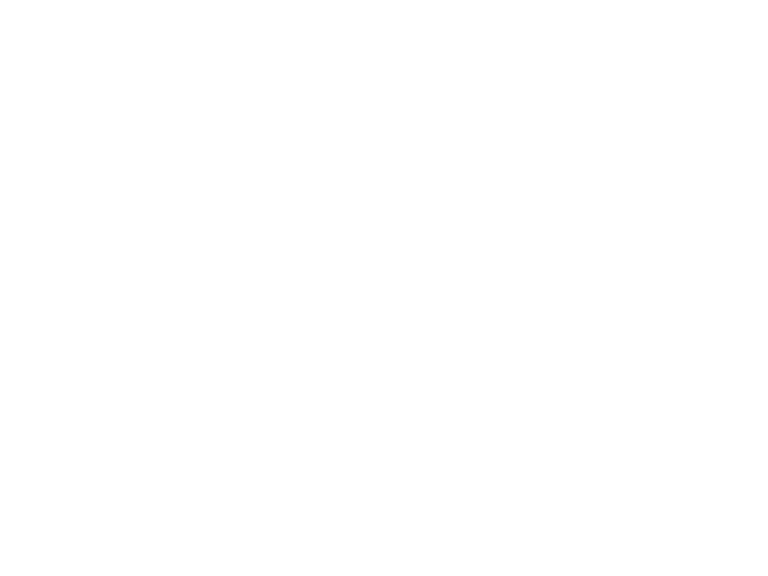

Run number 1


<IPython.core.display.Javascript object>


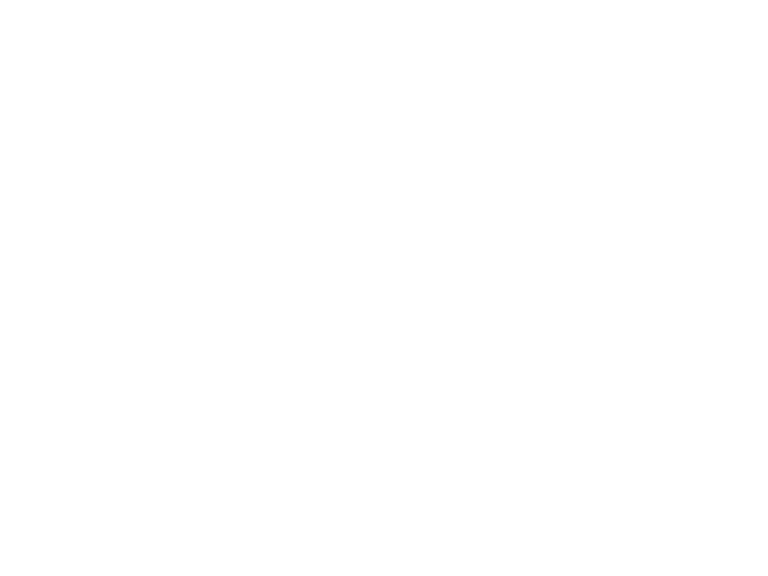

Run number 2


<IPython.core.display.Javascript object>


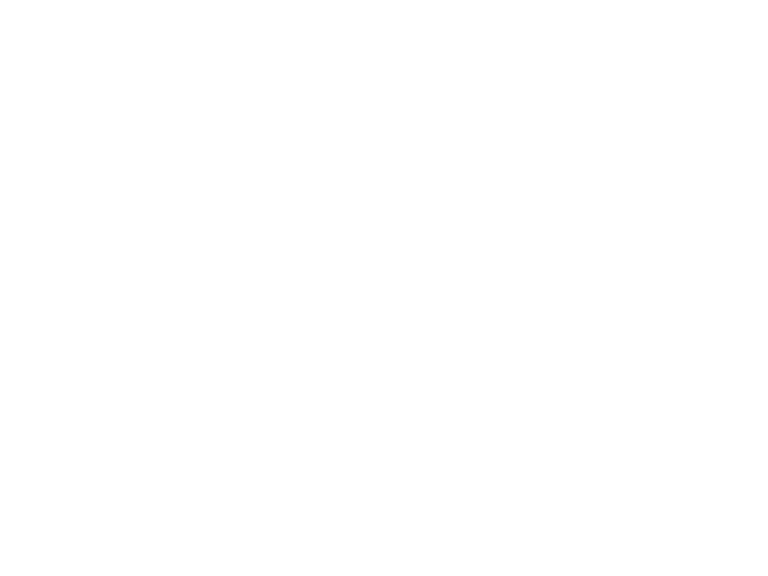

Run number 3


<IPython.core.display.Javascript object>


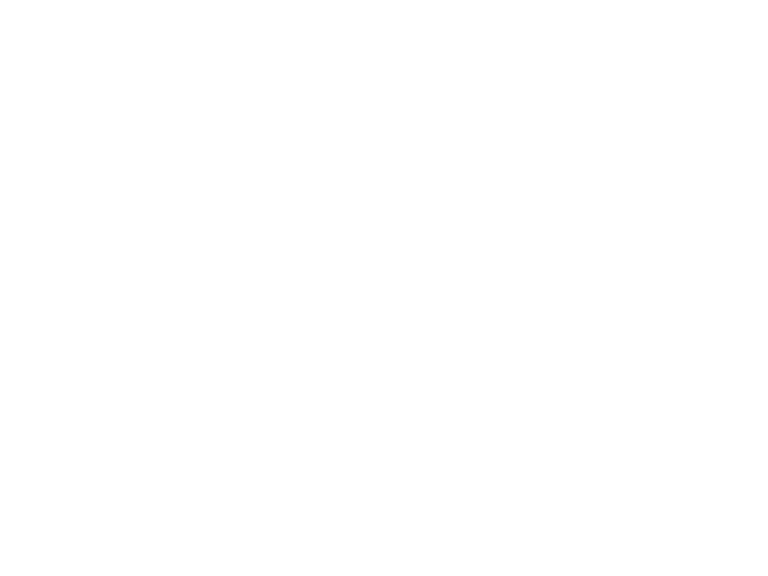

Run number 4


<IPython.core.display.Javascript object>


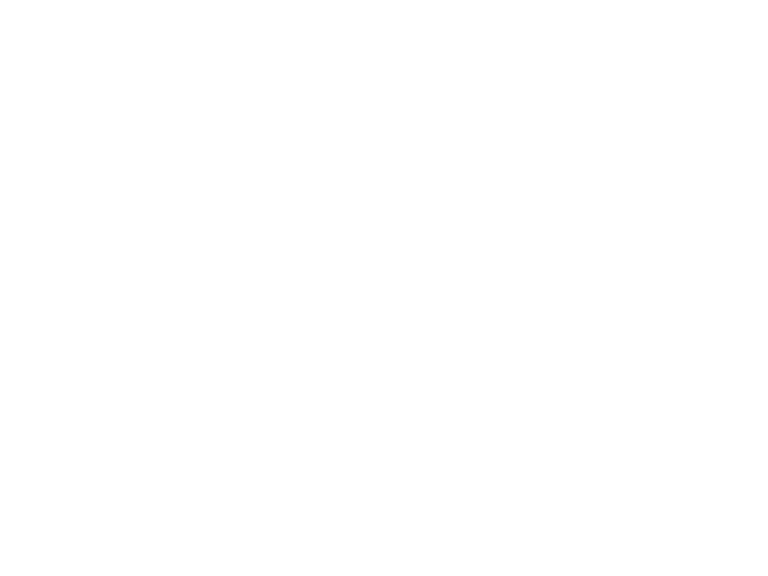

Run number 5


<IPython.core.display.Javascript object>


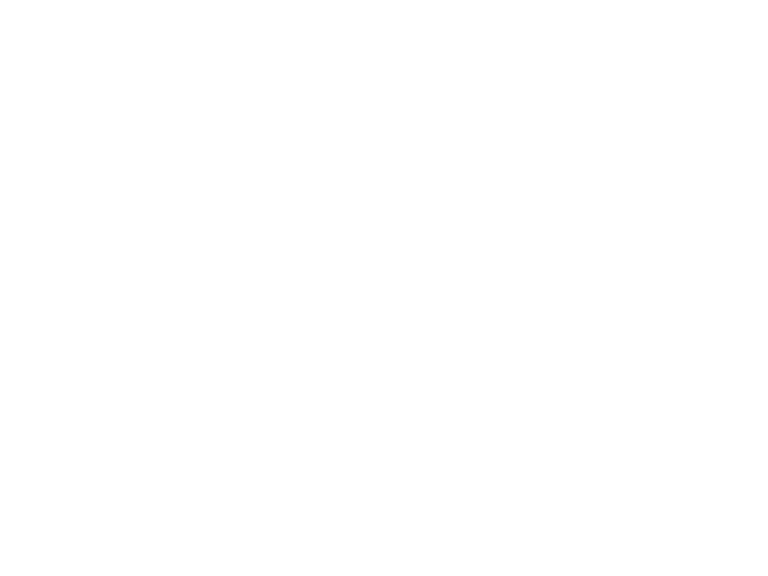

Run number 6


<IPython.core.display.Javascript object>


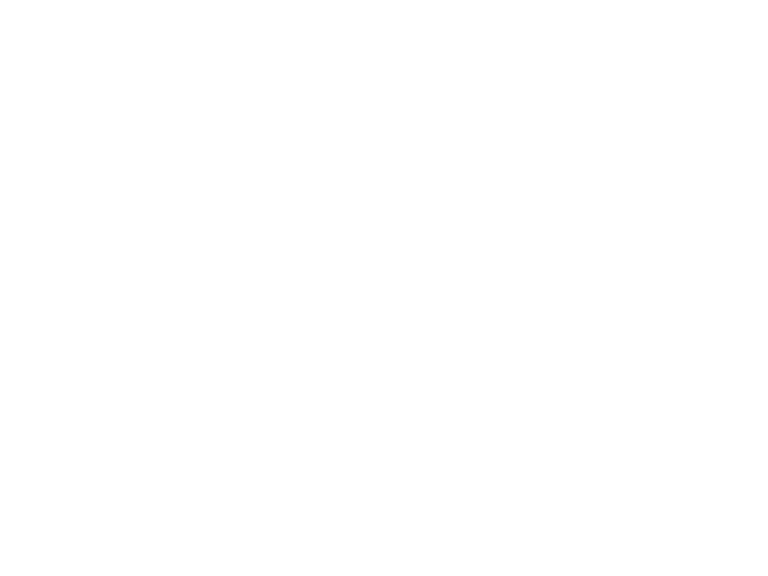

Run number 7


<IPython.core.display.Javascript object>


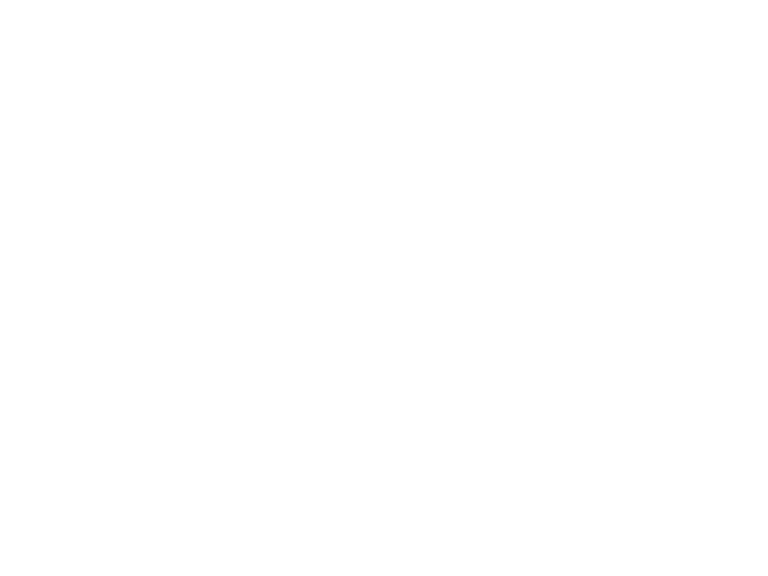

Run number 8


<IPython.core.display.Javascript object>


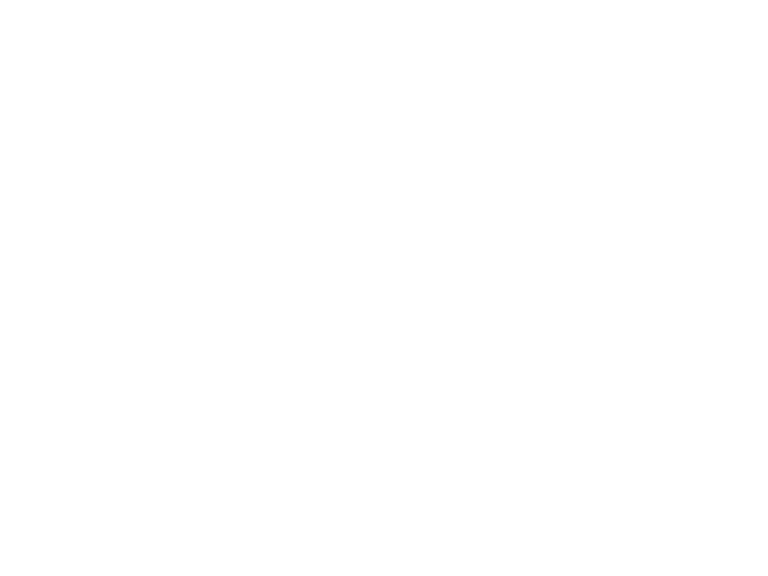

Run number 9


<IPython.core.display.Javascript object>


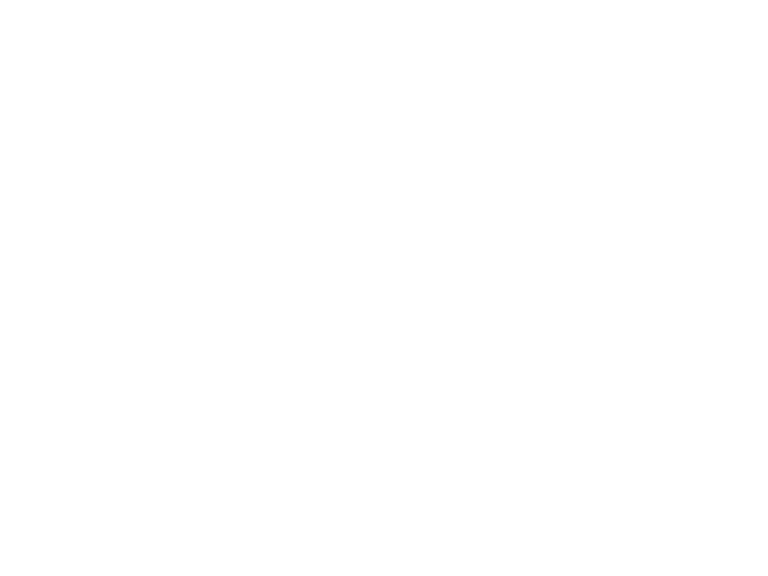

Run number 10


<IPython.core.display.Javascript object>


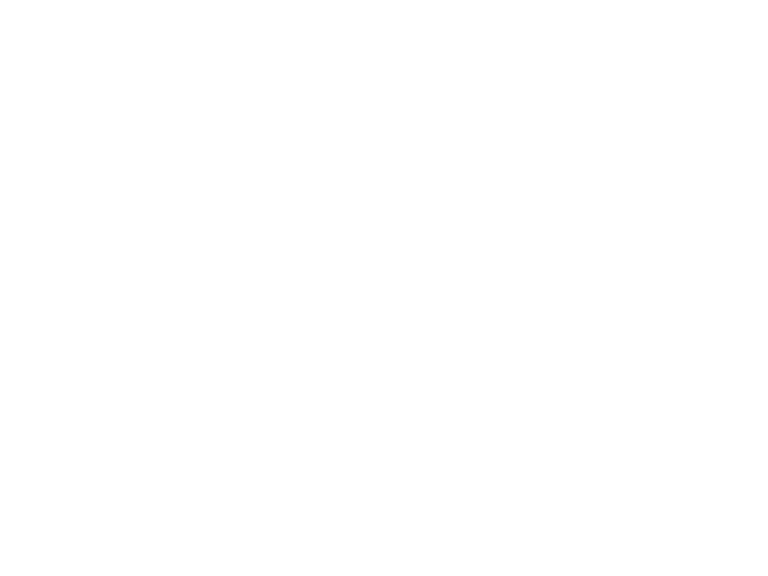

Run number 11


<IPython.core.display.Javascript object>


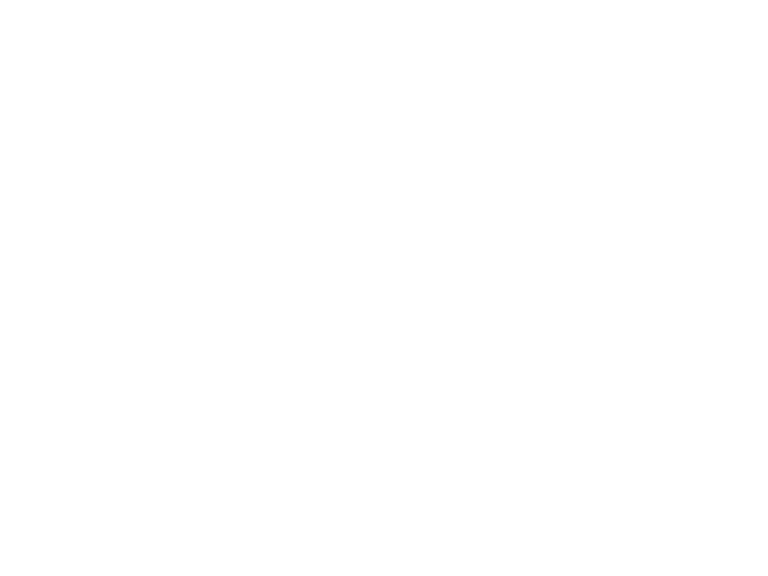

Run number 12


<IPython.core.display.Javascript object>


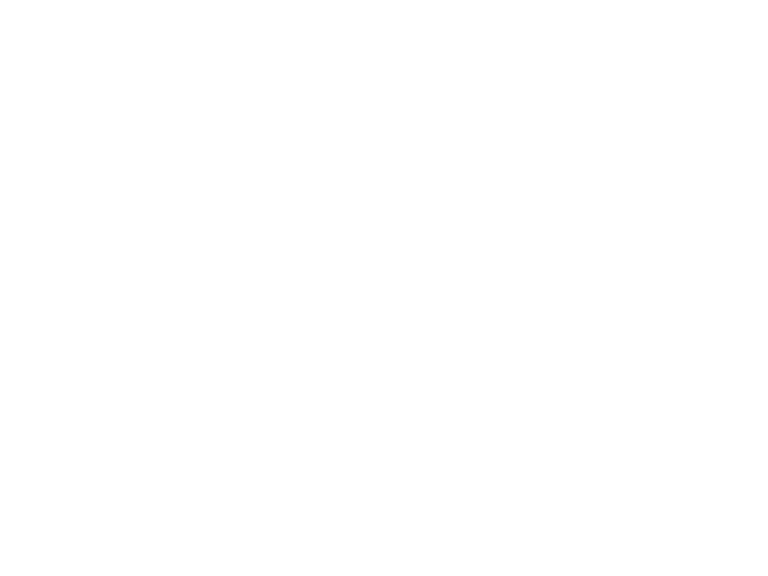

Run number 13


<IPython.core.display.Javascript object>


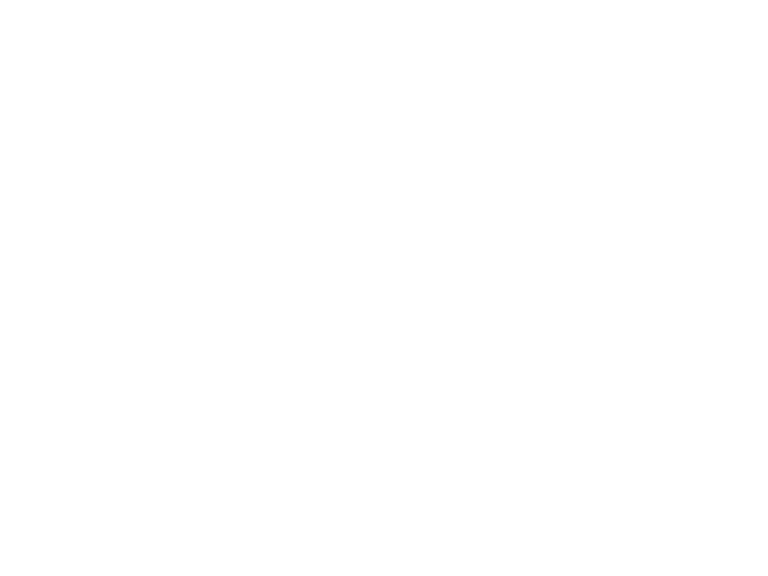

Run number 14


<IPython.core.display.Javascript object>


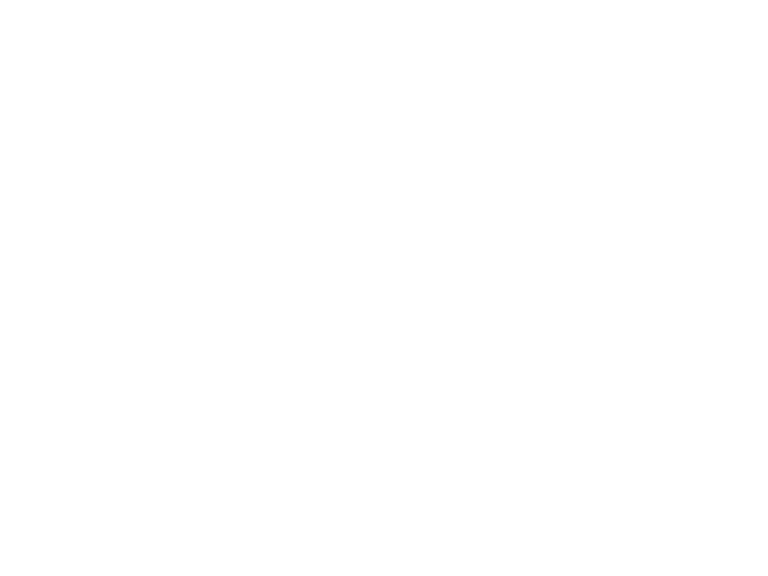

<IPython.core.display.Javascript object>


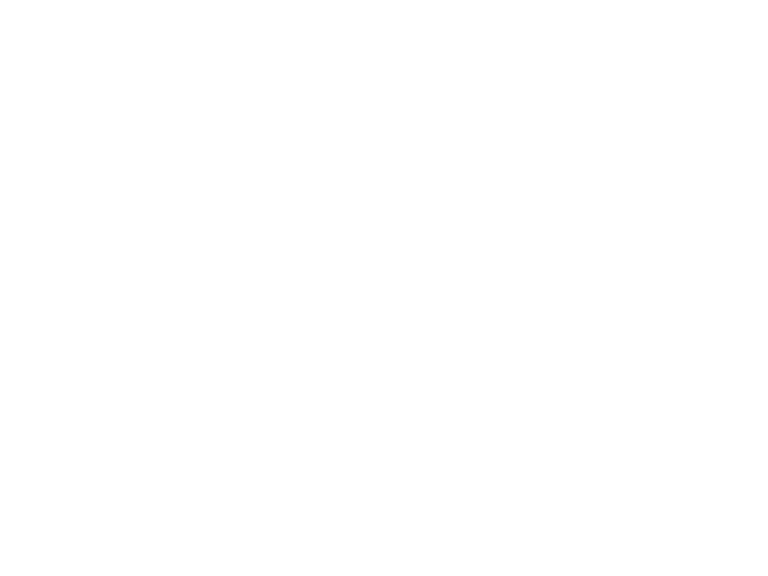

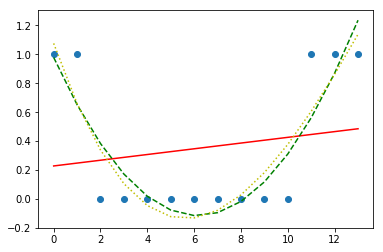

Slope and intercepts in ascending orders 
[0.01978022 0.22857143]
[ 0.02884615 -0.35521978  0.97857143]
[-0.00113122  0.05090498 -0.46574014  1.07563025]


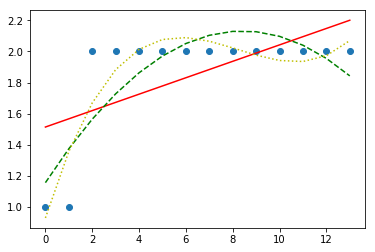

Slope and intercepts in ascending orders 
[0.05274725 1.51428571]
[-0.01373626  0.23131868  1.15714286]
[ 0.00263952 -0.06520685  0.48919953  0.93067227]


SystemExit: 0

/home/gamma/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
#Define constants here
global target_runs
global individual

target_runs = 14 #3.5 hours
individual = 22 #Pioneer-Boni

#Libraries For Scheduling
import schedule
import time
import datetime
import os, os.path 
from sys import exit

#Libraries for visualization (make global imports later)
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
southbound_data = [] #append southbound data of individual here.
northbound_data = [] #append northbound data of individual here. 
 
def visualize_individual(name, data, bound): 
    %matplotlib notebook
    length = len(data)
    
    x = range(0,length)
    y = data

    fig, ax = plt.subplots()
    ax.plot(x, y)

    ax.set(xlabel='Time steps', ylabel='Volume',title= name + " "+ bound + "Traffic")
    ax.grid()

    fig.savefig(name+ "_" + bound + "_traffic.png")

def analyze(data, target_runs, bound):
    %matplotlib inline 
    x = range(0,target_runs)
    x = np.array(x)
    data = np.array(data)
    
    p1 = np.polyfit(x,data,1) #order 1
    p2 = np.polyfit(x,data,2) #order 2
    p3 = np.polyfit(x,data,3) #order 3
   
    
    #plot data and linear fit
    plt.plot(x,data,'o')
    plt.plot(x,np.polyval(p1,x),'r-')
    plt.plot(x,np.polyval(p2,x),'g--')
    plt.plot(x,np.polyval(p3,x),'y:') 
    plt.savefig("Polynomial regression of "+ bound +" traffic data.png")
    plt.show()
    
    print("Slope and intercepts in ascending orders ")
    print(p1)
    print(p2)
    print(p3)

def job():
    #extract data at current time stamp
    list_of_lists = data_extraction()
        
    #save data of individual so far.
    southbound_data.append(list_of_lists[1][individual])
    northbound_data.append(list_of_lists[2][individual])
        
    #visualize overall data.
    visualize_overall(list_of_lists[0],list_of_lists[1],list_of_lists[2],list_of_lists[3])
        
    #track number of runs.
    num_of_runs = (len([file for file in os.listdir('.') if file.endswith('.png')]))
    print("Run number " + str(num_of_runs))
        
    #if target of runs has been reached, visualize individual data.
    if (num_of_runs == target_runs):
        visualize_individual(list_of_lists[0][individual],southbound_data,"Southbound")
        visualize_individual(list_of_lists[0][individual],northbound_data,"Northbound")
        analyze(southbound_data, target_runs,"Southbound")
        analyze(northbound_data, target_runs,"Northbound")
        exit(0) #exit program!
    
schedule.every(15).minutes.do(job)
    
while 1:
    schedule.run_pending()
    time.sleep(1) 